In [16]:
from datetime import datetime
from statistics import mean
from urllib import parse

import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from pandas.core import frame
from scipy.stats import bootstrap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [17]:
def analysis(data):
    views = []
    timestamp = []

    for entry in data:
        article = entry['article']
        timestamp.append((entry['timestamp']))
        views.append((entry['views']))

    return data

In [19]:
URL = "https://wikimedia.org/api/rest_v1/"
HEADERS = {"Accept": "application/json", "user-agent": "marvin.braun1@smail.inf.h-brs.de"}
def get_pageviews(article: str, start: datetime, end: datetime, project="de.wikipedia.org",
                  access="all-access", agent="all-agents", granularity="daily"):
    """
        args:
            article: The name of the article
            start: Start date
            end: End date
            project: The domain, default en.wikipedia.org
            access: Type of the device, default all-access. other options(Desktop, mobile-app, mobile-web)
            agent: Type of the agent, default all-agents. other options(user, spider, automated)
            granularity: The time unit, default daily. Other options(monthly)

    """
    params = [
        "metrics",
        "pageviews",
        "per-article",
        project.capitalize(),
        access,
        agent,
        parse.quote(article),
        granularity,
        start.strftime("%Y%m%d"),
        end.strftime("%Y%m%d")
    ]
    url = URL + "/".join(params)
    return requests.get(url, headers=HEADERS).json()["items"]

In [20]:
def difference(views, views2, diffViews2):
    diffViews = (sum(diffViews2)) / len(views)

    for i in range(0, len(views2)):
        views2[i] = views2[i] + diffViews
    return views2

In [21]:
def pageviewget(name):
    syear = 2015
    start = datetime(syear, 1, 1)
    end = datetime.today()
    article = name

    data = get_pageviews(article, start, end, project="de.wikipedia.org")

    views = []
    timestamp = []
    year = []
    zero = 0

    firstyear = [int(data[0]["timestamp"][0:4])]

    for entry in data:
        article = entry['article']
        timestamp.append((entry['timestamp']))
        views.append((entry['views']))

    return views

In [23]:
def get_back_links(article: str):
    S = requests.Session()
    URL = "https://de.wikipedia.org/w/api.php"

    PARAMS = {
        "action": "query",
        "bltitle": article,
        "bllimit": "50",
        "format": "json",
        "list": "backlinks",
    }

    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()
    BACKLINKS = DATA["query"]["backlinks"]
    blinks = []

    for b in BACKLINKS:
        blinks.append(b["title"])

    return blinks

In [24]:
def analyse(mainpage):
    mainviews = pageviewget(mainpage)
    backlinksMainview = get_back_links(mainpage)
    first20entrys = backlinksMainview[0:20]
    summe = []

    for entry in mainviews:
        summe.append(0)

    for entry in first20entrys:
        views = pageviewget(entry)
        differenceViews = [abs(m - km) for m, km in zip(mainviews, views)]
        newDifference = difference(mainviews, views, differenceViews)
        i = 1.00

        # diff = [abs(s - m) for s, m in zip(mainviews, views)]
        summe = [(km + bm) for km, bm in zip(summe, newDifference)]

        '''
        summe2 = summe

        while (sum(diff) / len(diff)) > 100:
            summe2 = [(i * km + i * bm) for km, bm in zip_longest(summe2, newDifference)]
            diff = [abs(s - m) for s, m in zip_longest(mainviews, summe2)]
            i = i - 0.01

        print("hahahahah")
        summe = summe2
        '''

    return summe

In [25]:
def lineareRegression(article):
    mainviews = pageviewget(article)
    backlinksMainview = get_back_links(article)
    first20entrys = backlinksMainview[0:20]
    df = pd.DataFrame()
    len1 = len(mainviews)

    for entry in first20entrys:
        views = pageviewget(entry)
        len2 = len(views)
        if len2 < len1:
            diff = len1 - len2
            for i in range(0, diff):
                views.append(0)

        df.insert(loc=0, column=entry, value=views)

    data = get_pageviews(article, datetime(2015, 1, 1), datetime.today(), project="de.wikipedia.org")
    data2 = analysis(data)

    x = df
    y = mainviews

    model = LinearRegression()
    model.fit(x, y, 0.2)

    x2 = np.linspace(2015, 2022.5, num=len(mainviews))

    intercept = model.intercept_
    slope = model.coef_[0]
    r_sq = model.score(x, y)

    print("intercept:", intercept)
    print("slope:", slope)
    print("coefficient of determination:", r_sq)

    yhat = model.predict(x)
    yhat[yhat < 0] = 0

    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.3,
                                                        random_state=None)
    lr = LinearRegression()
    lr.fit(x_train, y_train)

    print('------ Lineare Regression -----')
    print('Funktion via sklearn: y = %.3f * x + %.3f' % (lr.coef_[0], lr.intercept_))
    print("Alpha: {}".format(lr.intercept_))
    print("Beta: {}".format(lr.coef_[0]))
    print("Training Set RÂ² Score: {:.2f}".format(lr.score(x_train, y_train)))
    print("Test Set RÂ² Score: {:.2f}".format(lr.score(x_test, y_test)))
    print("\n")

    plt.scatter(mainviews, yhat, alpha=0.7)
    plt.title("Lineare Regression")
    plt.xlabel("Views Backlinks")
    plt.ylabel("Views: " + article)
    ax = plt.gca()
    line = mlines.Line2D([0, 1], [0, 1], color="red")
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    print(ax)
    plt.show()
    return intercept, slope, r_sq

In [26]:
def berechneDaten(alpha, beta, entrys):
    summe = []
    for entry in entrys[0:20]:
        for views in range(0, len(entry)):
            summe.append((alpha * views + beta))

    return summe


def berechneSumme(alpha, beta, summe, scr, abw):
    i = 0
    print(max(summe))

    for entry in summe[0: len(summe)]:
        if entry > 500 * abw:
            entry = mean(summe)
            print(entry)

        summe[i] = (alpha + beta * entry) * (1 - scr)
        i += 1
    return summe

In [27]:
def abweichungsfaktor(summe, mainview):
    abw = [abs(s1 - m) for s1, m in zip(summe, mainview)]
    abw1 = (sum(abw)) / len(abw)
    return abw1

In [28]:
def smape(target, forecast):
    if type(target) == pd.core.frame.DataFrame:
        target = target.values

    denominator = np.abs(target) + np.abs(forecast)
    flag = denominator == 0.

    smape = 2 * (
        (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
    )
    return smape

In [29]:
def MAPE(target ,predicted):
    def mape(actual, pred):
        actual, pred = np.array(actual), np.array(pred)
        return (np.abs((actual - pred) / actual)) * 100

intercept: -31.976066318885046
slope: 0.19508259009255804
coefficient of determination: 0.881175863257685
------ Lineare Regression -----
Funktion via sklearn: y = 0.197 * x + -35.864
Alpha: -35.86405026458027
Beta: 0.19684406508208763
Training Set RÂ² Score: 0.88
Test Set RÂ² Score: 0.87


AxesSubplot(0.125,0.11;0.775x0.77)


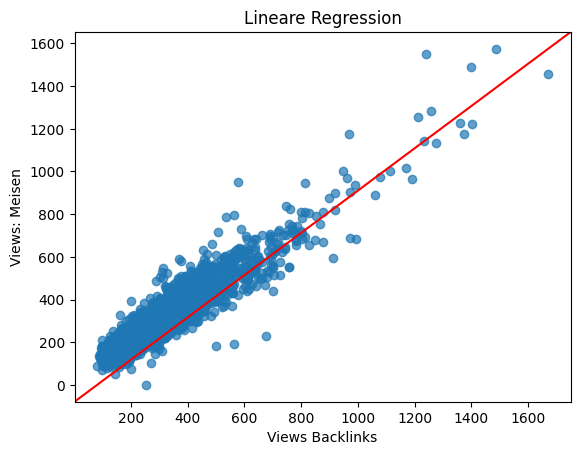

intercept: 32.20571010184233
slope: 0.09044901787164714
coefficient of determination: 0.5916751653937549
------ Lineare Regression -----
Funktion via sklearn: y = 0.095 * x + 14.708
Alpha: 14.708191464231277
Beta: 0.09484376956366329
Training Set RÂ² Score: 0.59
Test Set RÂ² Score: 0.59


AxesSubplot(0.125,0.11;0.775x0.77)


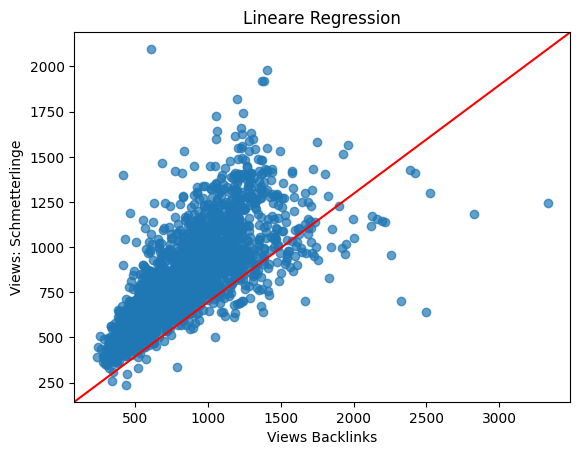

39764.421013960324


In [30]:
alphaMeisen, betaMeisen, score = lineareRegression("Meisen")
alpha2, beta2, score2 = lineareRegression("Schmetterlinge")

mainviews = pageviewget("Meisen")
backlinksMainview = get_back_links("Meisen")
first20entrys = backlinksMainview[0:20]
summe1 = analyse("Meisen")

abw2 = abweichungsfaktor(summe1, mainviews)
su = berechneSumme(alphaMeisen, betaMeisen, summe1, score, abw2)

In [39]:
mainviewsseq = (mainviews,)
bootstrap_ci = bootstrap(mainviewsseq,np.median, confidence_level=0.50,random_state=10,method='percentile')
print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=253.0, high=257.0)


In [ ]:
x1 = np.linspace(2015, 2022.5, num=len(su))
plt.plot(x1, su)
plt.xlabel("Time")
plt.ylabel("Views")
plt.title("Meisen Regression")
plt.show()

In [ ]:
x2 = np.linspace(2015, 2022.5, num=len(mainviews))
plt.plot(x2, mainviews)
plt.xlabel("Time")
plt.ylabel("Views")
plt.title("Meisen normal")
plt.show()